# 3 - CausalImpact Basics

### Causal Impact for Determining Paid Media Incremental Impact

Let's re-analyze our previous example, but this time let's imagine that we \*gasp\* don't have a suitable candidate for a geomatched control audience.

With Diff-in-Diff, we estimated the net impact by "forecasting" the expected value based on the actuals from the control audience




**How else could we estimate the counterfactual where we know what sales would look like if ads weren't disabled?**


We can use a method called **synthetic control** to come up with a statistical prediction of what our trend would look like in the future, if our intervention didn't occur. Then, we essentially do a diff-in-diff between the forecast & our actual trend to estimate the incremental impact.


For this example, we'll use a library called CausalImpact. To build a Causal Impact Model you need to specify:
 - A response time series (here, we'll use Goals MAU)
 - Specific date ranges for pre- and post- intervention
 - (Optionally) Other control time series that could make . This is like the Diff-in-Diff reference series, but instead of literally using this as a reference, these are used to improve the forecast of the model


Now all it does is estimate a control time series for the response, which represents the response time series if the intervention hadn’t happened.

This estimation is made using a Bayesian structural time series model trained on the input set of control time series. It is a Bayesian model, thus it gives a whole distribution for each point in the time series, which helps in knowing how sure you can be on the prediction. Finally, comparing this prediction with the real observations gives the distribution of the causal effect, which we can use to asses the impact.  ([thanks to theodo for helping me explain](https://data-ai.theodo.com/blog-technique/ab-testing-not-enough-google-causal-impact-insights))


In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from causalimpact import CausalImpact

In [2]:
df = pd.read_parquet('data/rossmann_sales.parquet')
df.set_index('date', inplace=True)
df.head()

geo_group,dayofweek,all_others,control_baseline,test_holdout,total_sales
date,,,,,
2015-02-01,7,115495,86226,23835.0,225556.0
2015-02-02,1,5707656,2772545,1810971.0,10291172.0
2015-02-03,2,4938248,2377591,1588841.0,8904680.0
2015-02-04,3,4486048,2200883,1449143.0,8136074.0
2015-02-05,4,4396477,2152077,1425362.0,7973916.0


Let's "forget" about our control group!

In [3]:
df['all_but_test_group']  = df['total_sales'] - df['test_holdout'] 
df.drop(columns=['total_sales', 'dayofweek'], inplace=True)
df.head()

geo_group,all_others,control_baseline,test_holdout,all_but_test_group
date,,,,
2015-02-01,115495,86226,23835.0,201721.0
2015-02-02,5707656,2772545,1810971.0,8480201.0
2015-02-03,4938248,2377591,1588841.0,7315839.0
2015-02-04,4486048,2200883,1449143.0,6686931.0
2015-02-05,4396477,2152077,1425362.0,6548554.0


In [4]:
test_date = dt.datetime(2015, 5, 1)

<Figure size 640x480 with 0 Axes>

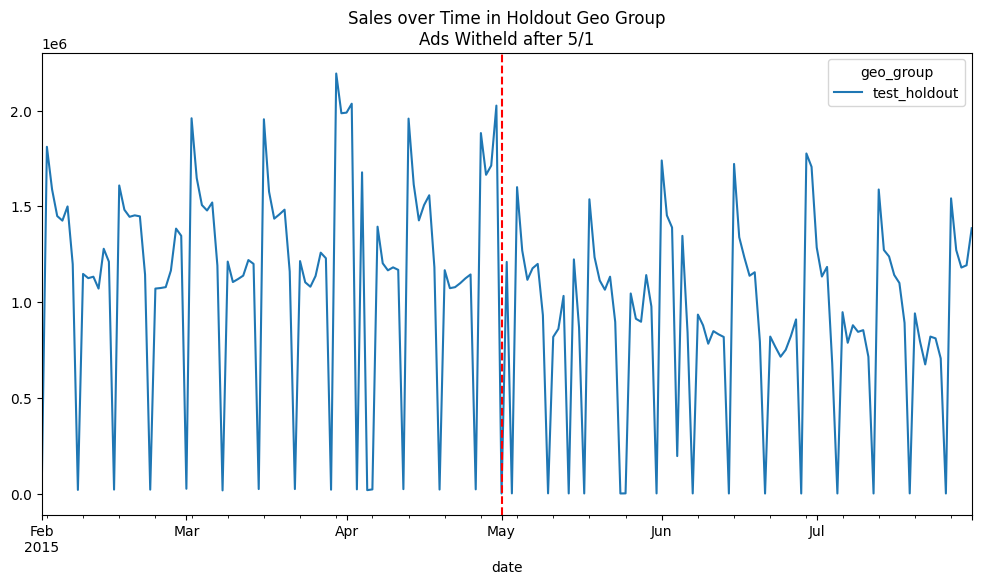

In [5]:
plt.figure()
df.plot(y=['test_holdout'], figsize=(12,6), title='Sales over Time in Holdout Geo Group\nAds Witheld after 5/1')
plt.axvline(test_date, color='r', linestyle='--')
plt.show()


This is the trend for ONLY sales in our test/holdout geographies.

Let's build a CausalImpact model to try to see how good the naive forecast can be.

In [ ]:
ci1 = CausalImpact(
    data= df['test_holdout'],
    pre_period= ['2015-02-01', '2015-04-30'],
    post_period= ['2015-05-01', '2015-07-31'],
)


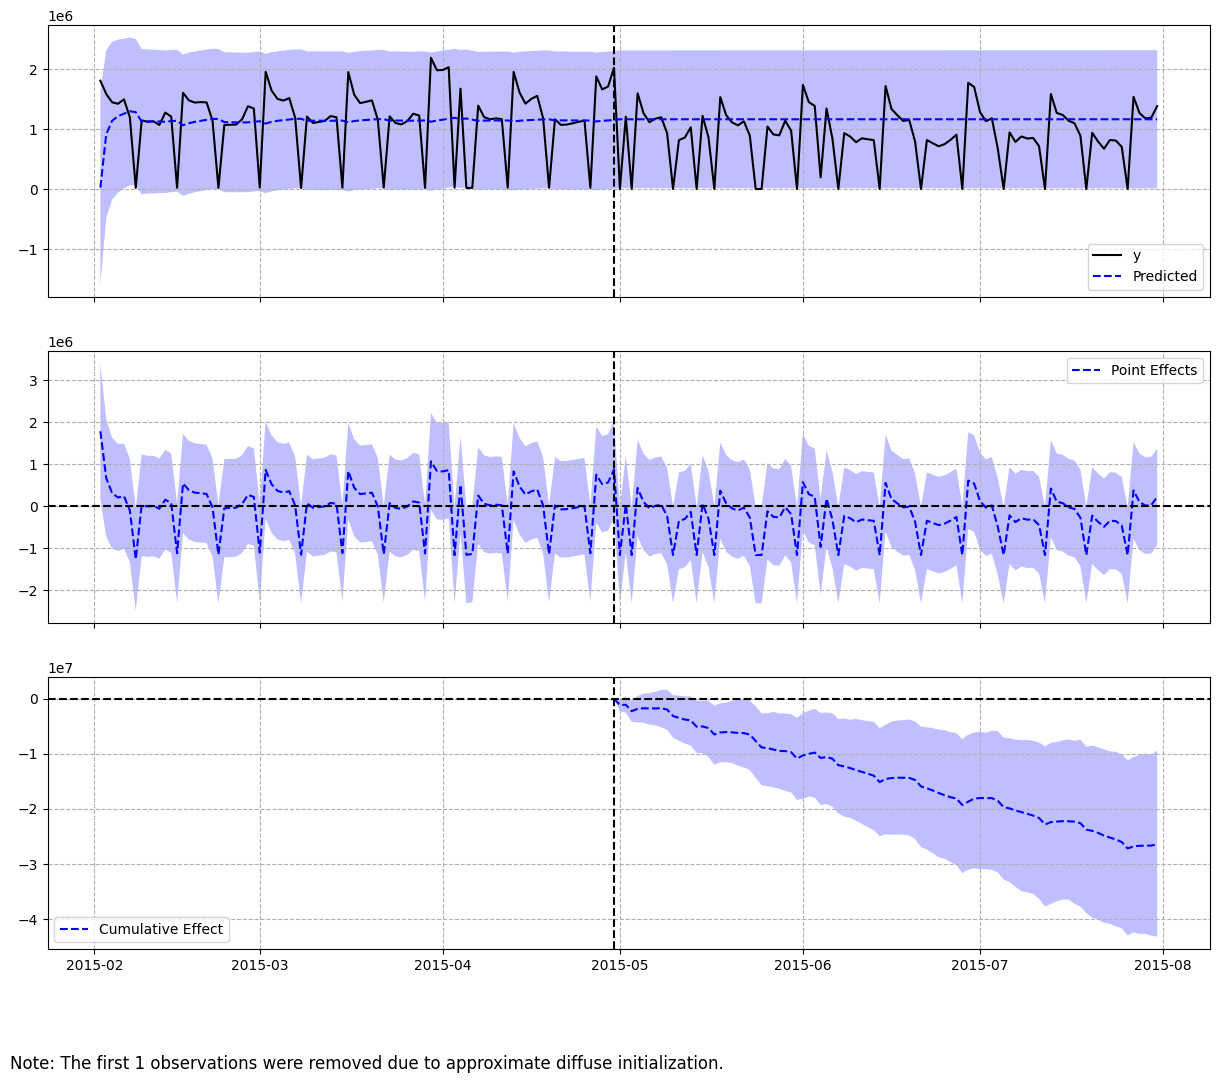

In [7]:
ci1.plot()

In [8]:
print(ci1.summary())


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    878393.88          80812236.99
Prediction (s.d.)         1165994.47 (93580.79)107271491.66 (8609432.65)
95% CI                    [981263.27, 1348093.22][90276220.62, 124024576.48]

Absolute effect (s.d.)    -287600.59 (93580.79)-26459254.67 (8609432.65)
95% CI                    [-469699.34, -102869.39][-43212339.49, -9463983.63]

Relative effect (s.d.)    -24.67% (8.03%)    -24.67% (8.03%)
95% CI                    [-40.28%, -8.82%]  [-40.28%, -8.82%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.8%

For more details run the command: print(impact.summary('report'))


Our Naive CI model estimates about a $288k daily decrease in sales due to disabling ads. Our Diff-in-Diff model estimatesd around 320k. Not bad, considering that we didn't have any geomatching to use as a control!!

We generally judge the quality of the forecast by the Posterior Probability. I'm actually surprised that this fit seems to be so strong (p = 0), but you can see that in the pre-treatment period we're missing some seasonality trends.


Let's build a second model that factors in weekly seasonality

In [ ]:
ci2 = CausalImpact(
    data= df['test_holdout'],
    pre_period= ['2015-02-01', '2015-04-30'],
    post_period= ['2015-05-01', '2015-07-31'],
    nseasons=[{'period': 7}],
    seasonal_duration=1
)



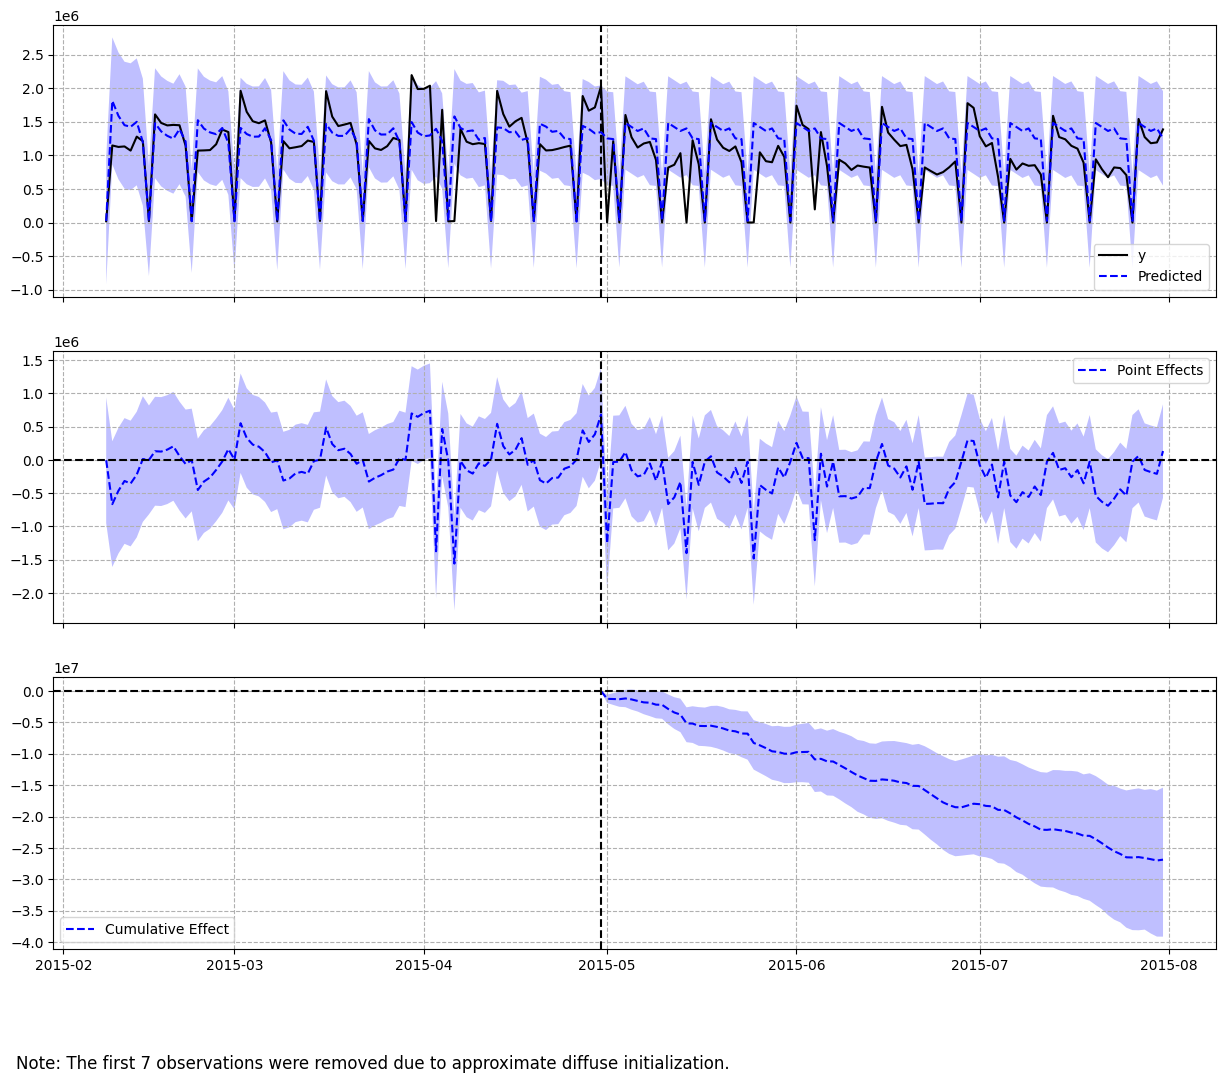

In [10]:
ci2.plot()

In [11]:
print(ci2.summary())
# print(ci1.summary('report'))

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    878393.88          80812236.99
Prediction (s.d.)         1170395.89 (65824.82)107676422.33 (6055883.53)
95% CI                    [1045654.5, 1303683.06][96200214.39, 119938841.6]

Absolute effect (s.d.)    -292002.01 (65824.82)-26864185.34 (6055883.53)
95% CI                    [-425289.18, -167260.62][-39126604.61, -15387977.4]

Relative effect (s.d.)    -24.95% (5.62%)    -24.95% (5.62%)
95% CI                    [-36.34%, -14.29%] [-36.34%, -14.29%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Visually, you can see that the CI model fits the data MUCH better in the pre-period once we add in weekly seasonality, which gives us more ocnfidence that the synthetic forecast in the post-period will be more relatiable.


You can also see that we do a better job of repeating the results of our the analysis with a true geomatched control, now that we're estimating 

Let's see if adding in Training Plan MAU as a reference trend can improve our fit

In [ ]:
ci3 = CausalImpact(
    data= df[['test_holdout', 'all_but_test_group']],
    pre_period= ['2015-02-01', '2015-04-30'],
    post_period= ['2015-05-01', '2015-07-31'],
    nseasons=[{'period': 7}],
    seasonal_duration=1
)



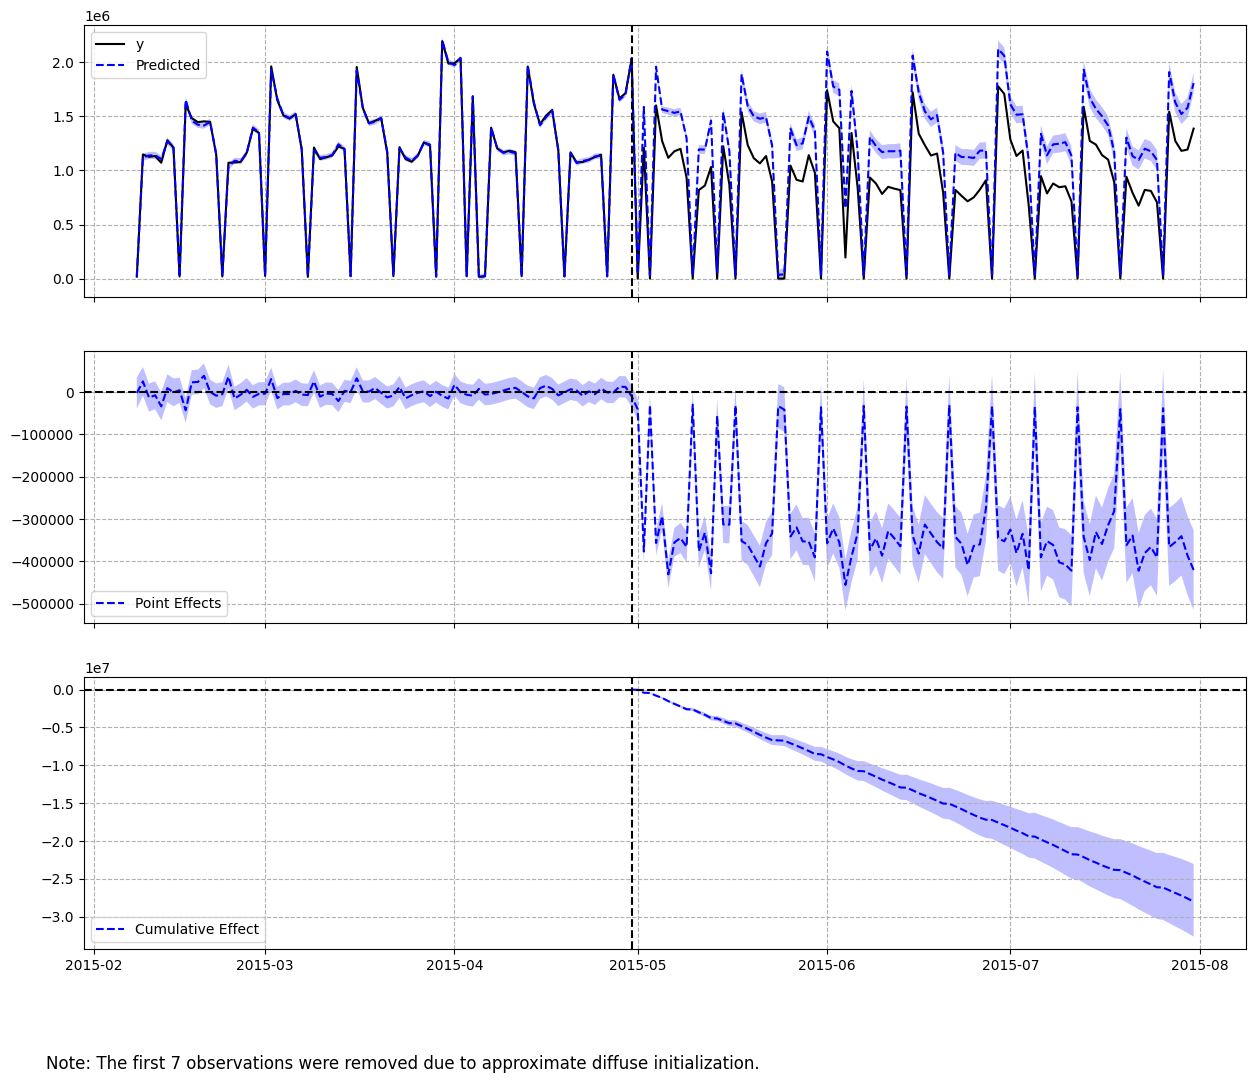

In [13]:
ci3.plot()

In [14]:
print(ci3.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    878393.88          80812236.99
Prediction (s.d.)         1182935.18 (26604.89)108830036.62 (2447649.54)
95% CI                    [1128874.76, 1233164.0][103856478.0, 113451087.88]

Absolute effect (s.d.)    -304541.3 (26604.89)-28017799.63 (2447649.54)
95% CI                    [-354770.12, -250480.88][-32638850.89, -23044241.01]

Relative effect (s.d.)    -25.74% (2.25%)    -25.74% (2.25%)
95% CI                    [-29.99%, -21.17%] [-29.99%, -21.17%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Fit looks MUCH better, and we saw the effect size change! 

Now the estimated effect size is approximately $304.5k / day in sales

Having a reference trend was very helpful for improving our fit in the pre-period and for predicting more anomalyous "bumps" in the post-period


For fun, let's repeat the Diff-in-Diff analysis using our actual geomatched control group, but using the CausalImpact package

In [ ]:
ci4 = CausalImpact(
    data= df[['test_holdout', 'control_baseline']],
    pre_period= ['2015-02-01', '2015-04-30'],
    post_period= ['2015-05-01', '2015-07-31'],
    nseasons=[{'period': 7}],
    seasonal_duration=1
)



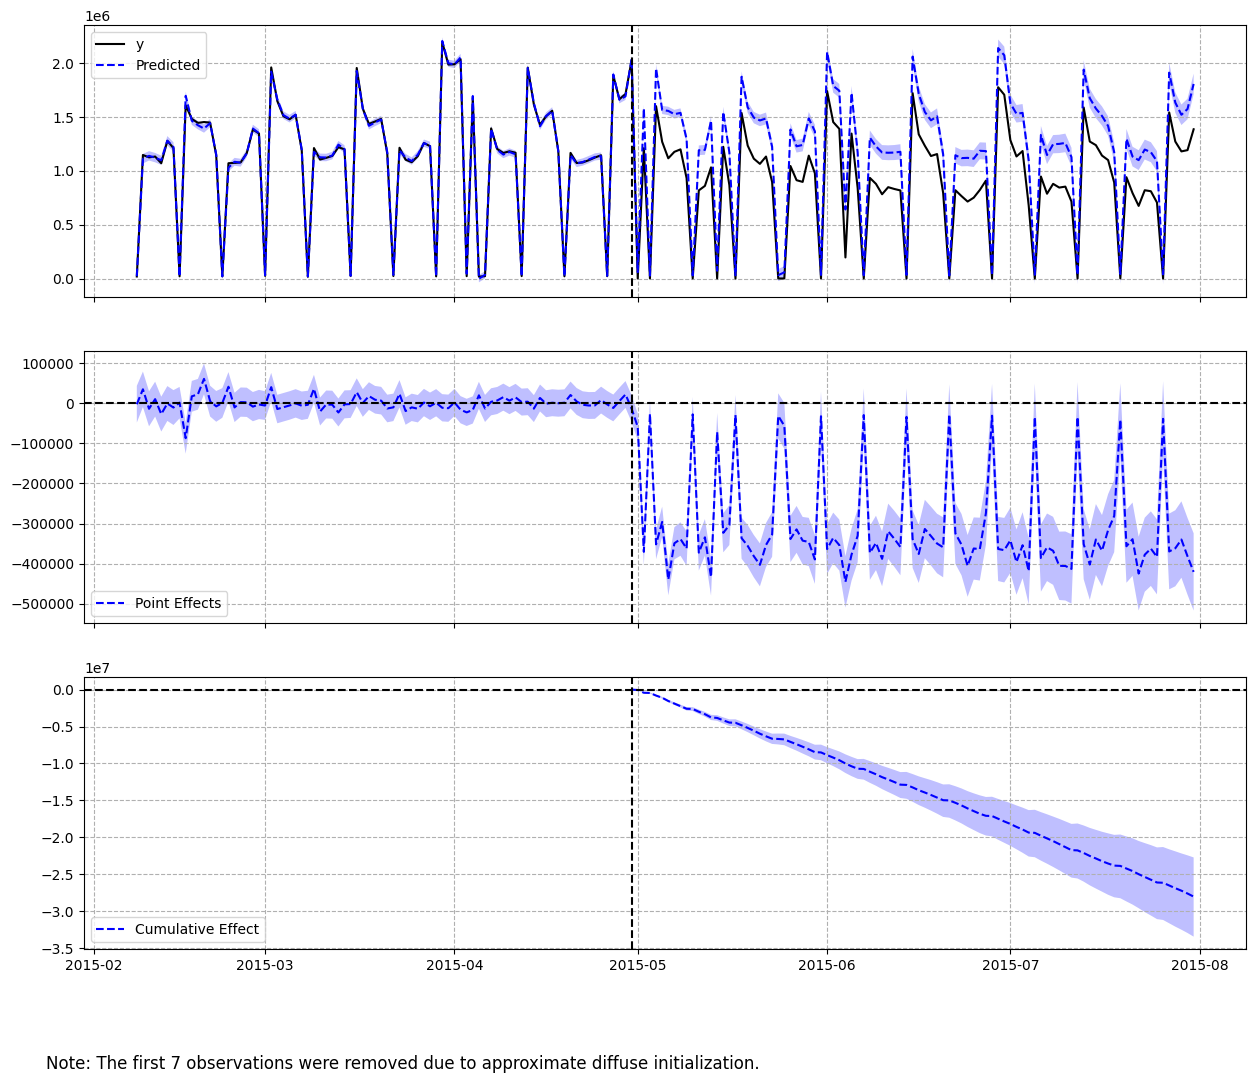

In [16]:
ci4.plot()

In [17]:
print(ci4.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    878393.88          80812236.99
Prediction (s.d.)         1182900.04 (29722.58)108826803.6 (2734477.03)
95% CI                    [1125254.4, 1241764.76][103523405.05, 114242358.03]

Absolute effect (s.d.)    -304506.16 (29722.58)-28014566.61 (2734477.03)
95% CI                    [-363370.88, -246860.52][-33430121.04, -22711168.06]

Relative effect (s.d.)    -25.74% (2.51%)    -25.74% (2.51%)
95% CI                    [-30.72%, -20.87%] [-30.72%, -20.87%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


CausalImpact believes that the actual effect size is smaller than the traditional Geotest does.


Which should we trust more?


.... it's complicated!